Copyright (c) 2022 Graphcore Ltd. All rights reserved.

*Notebook autogenerated from OptimumWalkthrough.py on 16-Jun-2022*

Graphcore-optimum ViT demo on Chest X-ray Dataset
=================================================

First install the required packages.

In [1]:
get_ipython().run_line_magic('pip', 'install pandas datasets torchvision==0.11.1 transformers optimum optimum-graphcore scikit-learn==0.24.2 matplotlib')

Looking in indexes: https://pypi.org/simple, https://pypi.python.org/simple/


You should consider upgrading via the '/localdata/alexandrec/sdks/poplar_sdk-ubuntu_18_04-2.6.0-EA.1+1025-ae1b174852/2.6.0-EA.1+1025_poptorch/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import os
import optimum.graphcore as optimum_graphcore
import transformers
import numpy as np
import pandas as pd
import contextlib
import io
from pathlib import Path
output = io.StringIO()

## Preparing the data

The NIH Chest X-ray Dataset can be download at https://nihcc.app.box.com/v/ChestXray-NIHCC

Bash to extract the files:
```
for f in images*.tar.gz; do tar xfz "$f"; done
```

First we set variables pointing to the directory where the dataset is saved:

In [3]:
dataset_rootdir = Path("/localdata/ai-datasets/NIH-Chest-XRay/").absolute()
# Path to the extracted "images" directory
images_dir = dataset_rootdir / "images"

# Path to Data_Entry_2017_v2020.csv
label_file = dataset_rootdir / 'Data_Entry_2017_v2020.csv'

# We are going to import HuggingFace model from the checkpoint `google/vit-base-patch16-224-in21k` in this demo
model_name_or_path = "google/vit-base-patch16-224-in21k"

### Preparing the labels

To be compatible with the `datasets` HuggingFace library the text labels need to be transformed to N-hot encoded arrays representing the multiple label which are needed to classify each example.

First we identify the unique labels in the dataset:

In [4]:
data = pd.read_csv(label_file)

data['Finding Labels'] = data['Finding Labels'].str.replace('No Finding', 'No_Finding')
unique_labels = np.unique(data['Finding Labels'].str.split("|").aggregate(np.concatenate)).tolist()

print(f"Dataset contains the following labels:\n{unique_labels}")

Dataset contains the following labels:
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Now we transform the labels into N-hot encoded labelling arrays:

In [5]:
label_index = {v: i for i, v in enumerate(unique_labels)}
    
def string_to_N_hot(string: str):
    true_index = [label_index[cl] for cl in string.split("|")]
    label = np.zeros((len(unique_labels),), dtype=float)
    label[true_index] = 1
    return label

data["labels"] = data["Finding Labels"].apply(string_to_N_hot)

To interface with the `datasets.load_dataset` function we need to write the image file names and their associated labels to a
`metadata.jsonl` file ([see documentation](https://huggingface.co/docs/datasets/v2.3.2/en/image_process#imagefolder)).

In [6]:
data[["Image Index", "labels"]].rename(columns={"Image Index" : "file_name"}).to_json(images_dir / 'metadata.jsonl', orient='records', lines=True)

### Create the dataset

We are now ready to create the Pytorch dataset and split it into training and validation sets (can take a few minutes).

In [7]:
import datasets

train_val_split = 0.1
dataset = datasets.load_dataset(
    "imagefolder",
    data_dir=images_dir,
)

split = dataset["train"].train_test_split(train_val_split)
dataset["train"] = split["train"]
dataset["validation"] = split["test"]

Resolving data files:   0%|          | 0/112121 [00:00<?, ?it/s]

Using custom data configuration default-d9f38ef72de7a2a2


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /home/alexandrec/.cache/huggingface/datasets/image_folder/default-d9f38ef72de7a2a2/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
dataset['train'][18]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x7F93F516C278>,
 'labels': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0]}

Define data preprocessing steps using Pytorch transforms.

In [9]:
from torchvision import transforms

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    model_name_or_path
)


class XRayTransform:
    """
    Transforms for pre-processing XRay data across a batch.
    """
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Lambda(lambda pil_img: pil_img.convert("RGB")),
            transforms.Resize(feature_extractor.size),
            transforms.ToTensor(),
            transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ])

    def __call__(self, example_batch):
        example_batch["pixel_values"] = [self.transforms(pil_img) for pil_img in example_batch["image"]]
        return example_batch


# Set the training transforms
dataset["train"].set_transform(XRayTransform())
# Set the validation transforms
dataset["validation"].set_transform(XRayTransform())

Finally, define a data collator that will be used to construct the batches.

In [10]:
def batch_sampler(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Visualise the data

Print the first 10 labels

In [11]:
data.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],labels
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,No_Finding,0,2,80,M,PA,2500,2048,0.171,0.171,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


Prepare the label mappings.
We'll include these in the model's config to get human readable labels in the Inference API.

Let's plot 12 images from the validation set with their associated labels.

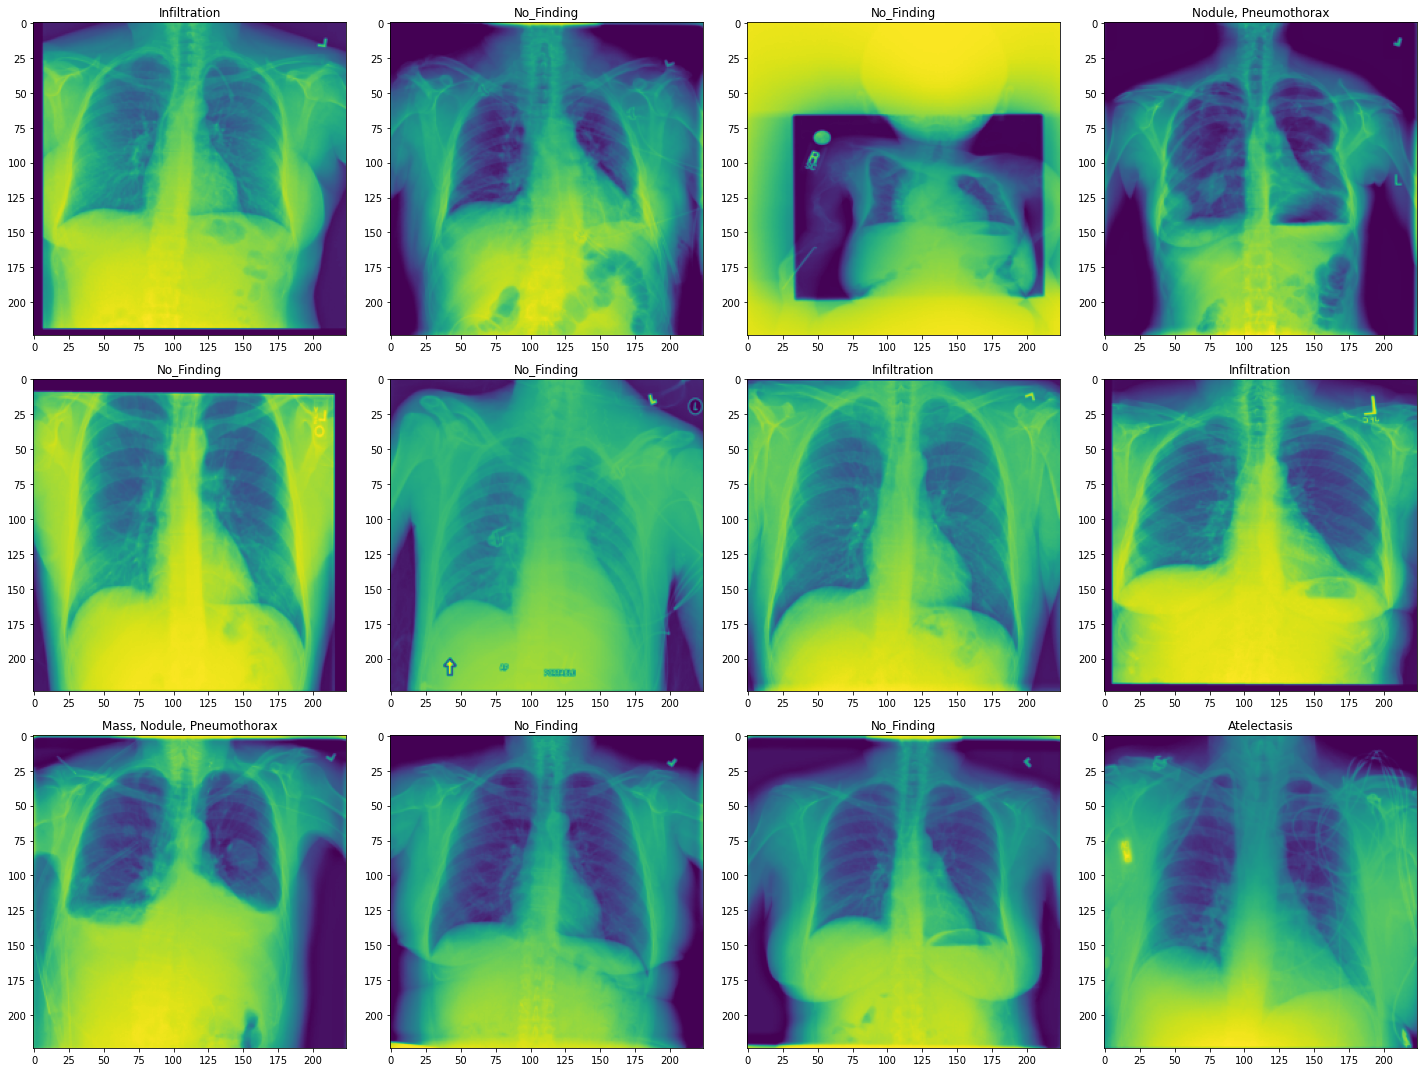

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 15))

unique_labels = np.array(unique_labels)

for i, data_dict in enumerate(dataset['validation']):
    if i == 12:
        break
    image = data_dict["pixel_values"]
    label = data_dict["labels"]
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title(", ".join(unique_labels[np.argwhere(label).flatten()]))
    plt.imshow(image[0])

fig.tight_layout()

## Preparing the model

Import the ViT model from HuggingFace.

In [13]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=15)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`IPUConfig` is a specific arguments class defined by Optimum-graphcore.
It gives control to all the parameters specific to Graphcore's IPUs.
Existing IPU configs can be found at : https://huggingface.co/Graphcore
We are going to use `Graphcore/vit-base-ipu`.

In [14]:
ipu_config = optimum_graphcore.IPUConfig.from_pretrained(
    "Graphcore/vit-base-ipu"
)

Let's set our training hyperparameters using `IPUTrainingArguments`.
This subclasses HuggingFace's `TrainingArguments` with additional parameters.

In [15]:
training_args = optimum_graphcore.IPUTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    dataloader_num_workers=8,
    dataloader_drop_last=True,
    num_train_epochs=3,
    seed=1337,
    logging_steps=50,
    save_steps=1000,
    remove_unused_columns=False,
    warmup_ratio=0.25,
    lr_scheduler_type="cosine",
    learning_rate=2e-4,
    ignore_data_skip=True
)

To assess the performance of the model we will use the area under the  ROC (receiver operating characteristic) curve for assessing the multi-label performance (`roc_auc`).
We obtain them using the dataset package.
Let's also define our `compute_metrics` function. It takes an `EvalPrediction` object (a namedtuple with a predictions and label_ids field) and has to return a dictionary string to float.

In [16]:
from scipy.special import softmax


metric_auc = datasets.load_metric("roc_auc", "multilabel")


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)

    pred_scores = softmax(p.predictions.astype('float32'), axis=1)
    auc = metric_auc.compute(prediction_scores=pred_scores, references=p.label_ids, multi_class='ovo')['roc_auc']
    return {"roc_auc": auc}

`IPUTrainer` works just like HF `Trainer`, it takes the additional `ipu_config` arguments.

In [17]:
trainer = optimum_graphcore.IPUTrainer(
    model=model,
    ipu_config=ipu_config,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    data_collator=batch_sampler,
)

Setting replicated_tensor_sharding to False when replication_factor=1
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------


## Run the training

To accelerate training we will load the last checkpoint if it exists

In [18]:
last_checkpoint = None
if os.path.isdir(training_args.output_dir) and not training_args.overwrite_output_dir:
    last_checkpoint = transformers.trainer_utils.get_last_checkpoint(training_args.output_dir)

Now we are ready to train.

In [19]:
with contextlib.redirect_stdout(output):
    trainer.train(resume_from_checkpoint = last_checkpoint)

Compiling Model...
/localdata/alexandrec/sdks/poplar_sdk-ubuntu_18_04-2.6.0-EA.1+1025-ae1b174852/2.6.0-EA.1+1025_poptorch/lib/python3.6/site-packages/transformers/models/vit/modeling_vit.py:186: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:
Graph compilation: 100%|██████████| 100/100 [03:58<00:00]
Compiled/Loaded model in 294.3308764528483 secs
***** Running training *****
  Num examples = 100908
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Device Iterations = 1
  Replication Factor = 1
  Gradient Accumulation steps = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Total optimization steps = 2364
wandb: Currently logged in as: alexandrec. Use `wandb login --re

  0%|          | 0/2364 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1000
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Configuration saved in ./results/checkpoint-1000/ipu_config.json
Saving model checkpoint to ./results/checkpoint-2000
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Configuration saved in ./results/checkpoint-2000/ipu_config.json


Training com

### Plotting convergence
Let's format the trainer output.

In [20]:
import json
# Visualise a fragment of the raw output
print(output.getvalue()[:500])
print("...")
print(output.getvalue()[-500:])

# Put the trainer logs in a data frame
values = []
for line in output.getvalue().split("\n"):
    if len(line) > 3 and line[:3] == "{'l":
        values.append(json.loads(line.replace("'", '"')))
training_records = pd.DataFrame(values)
training_records.tail(5)

{'loss': 0.6049, 'learning_rate': 1.6920473773265652e-05, 'epoch': 0.06}
{'loss': 0.4166, 'learning_rate': 3.3840947546531304e-05, 'epoch': 0.13}
{'loss': 0.3683, 'learning_rate': 5.076142131979695e-05, 'epoch': 0.19}
{'loss': 0.3005, 'learning_rate': 6.768189509306261e-05, 'epoch': 0.25}
{'loss': 0.2599, 'learning_rate': 8.460236886632826e-05, 'epoch': 0.32}
{'loss': 0.2438, 'learning_rate': 0.0001015228426395939, 'epoch': 0.38}
{'loss': 0.2248, 'learning_rate': 0.00011844331641285957, 'epoch':
...
: 0.1532, 'learning_rate': 7.103458838758869e-06, 'epoch': 2.73}
{'loss': 0.1834, 'learning_rate': 4.192583130930605e-06, 'epoch': 2.79}
{'loss': 0.1812, 'learning_rate': 2.0332218553618885e-06, 'epoch': 2.86}
{'loss': 0.1613, 'learning_rate': 6.423130656615483e-07, 'epoch': 2.92}
{'loss': 0.1546, 'learning_rate': 3.0767065682613116e-08, 'epoch': 2.98}
{'train_runtime': 994.926, 'train_samples_per_second': 304.268, 'train_steps_per_second': 2.376, 'train_loss': 0.2072382312135648, 'epoch': 

,loss,learning_rate,epoch
42,0.1532,7.103459e-06,2.73
43,0.1834,4.192583e-06,2.79
44,0.1812,2.033222e-06,2.86
45,0.1613,6.423131e-07,2.92
46,0.1546,3.076707e-08,2.98


Plot the training loss and the learning rate.

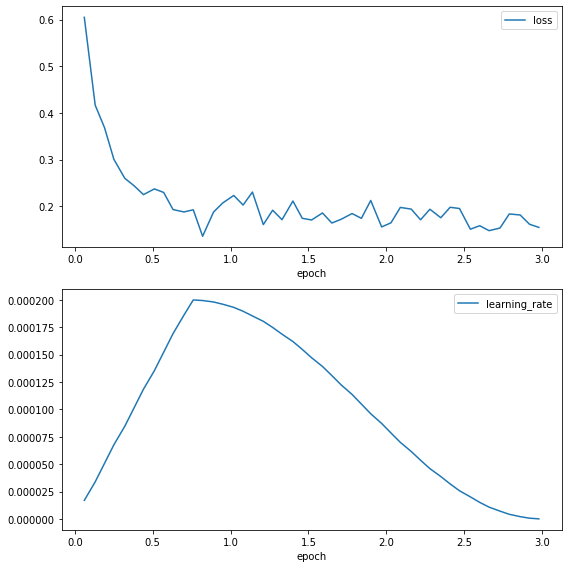

In [21]:
fig, axs = plt.subplots(2, 1)
training_records.plot(x="epoch", y="loss", ax=axs[0])
training_records.plot(x="epoch", y="learning_rate", ax=axs[1])
fig.set_size_inches(8, 8)
fig.tight_layout()

## Run the evaluation

In [22]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Compiling Model...
Graph compilation: 100%|██████████| 100/100 [01:10<00:00]
Compiled/Loaded model in 119.17617410421371 secs
***** Running Evaluation *****
  Num examples = 11212
  Batch size = 4


  0%|          | 0/2803 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_loss               =     0.1818
  eval_roc_auc            =     0.7811
  eval_runtime            = 0:01:23.11
  eval_samples_per_second =      134.9
  eval_steps_per_second   =     33.725


This basic demo achieved a validation AUC_ROC score of 0.78 after 3 epochs.
There are several directions to explore in order to improve it: longer training, data augmentation and hyperparameters tuning.

## Conclusion

Optimum-graphcore makes state-of-the-art models from HuggingFace available on IPU with a minimal amount of code.
Pre-set device parameters can be loaded and customised in `IPUConfig`.